In [1]:
!pip install vaderSentiment
!pip install gensim
!pip install imbalanced-learn --user
!pip install boto3

In [2]:
import numpy as np
import pandas as pd
import boto3
import tensorflow as tf
import mglearn
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import time
import warnings
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras import regularizers
warnings.filterwarnings("ignore")
#from keras.preprocessing import sequence

In [3]:
path = r"C:\Users\jackn\Documents\Machine Learning with Python\tidy_test_tweets.json"
df = pd.read_json(path, orient = 'table')

In [4]:
df.head()

,text,lemmatized,tokens_back_to_text
0,"[rudygiuliani, compete, town, hall, joke, step...","[rudygiuliani, compete, town, hall, joke, step...",rudygiuliani compete town hall joke stephanopo...
1,"[rachelv12, trump, machismo, tcoykfacdodju]","[rachelv12, trump, machismo, tcoykfacdodju]",rachelv12 trump machismo tcoykfacdodju
2,"[briantylercohen, biden, like, encyclopedia, t...","[briantylercohen, biden, like, encyclopedia, t...",briantylercohen biden like encyclopedia tonigh...
3,"[bradleywhitford, yo, semites, qanon, nt, hate...","[bradleywhitford, yo, semite, qanon, nt, hate,...",bradleywhitford yo semite qanon nt hate democr...
4,"[actbrigitte, retweet, president, trump, win, ...","[actbrigitte, retweet, president, trump, win, ...",actbrigitte retweet president trump win debate


In [5]:
tweets = list(df['tokens_back_to_text'])
print(type(tweets))

<class 'list'>


In [6]:
print(len(tweets))

10011


In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sa = SentimentIntensityAnalyzer()
sentiment = [sa.polarity_scores(tweet) for tweet in tweets]

In [8]:
sentiments = pd.DataFrame(sentiment, index = df.index)
print(sentiments.shape)

(10011, 4)


In [9]:
sentiments.head()

,neg,neu,pos,compound
0,0.000,0.739,0.261,0.5000
1,0.000,1.000,0.000,0.0000
2,0.000,0.690,0.310,0.5423
3,0.381,0.619,0.000,-0.8126
4,0.000,0.568,0.432,0.5859


In [10]:
sentiments.isnull().sum()

neg         0
neu         0
pos         0
compound    0
dtype: int64

In [11]:
compound = sentiments[['compound']].values

In [12]:
# We are now tagging the tweets with sklearn using the k-means algorithm. 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(compound)
labels = pd.DataFrame(kmeans.labels_, columns=['label'], index=df.index)
labels.head()

,label
0,0
1,0
2,0
3,1
4,0


In [13]:
# What do these outputs mean? (I think that it means that they are negative or positive)

In [14]:
labels['label'].value_counts()

0    7059
1    2952
Name: label, dtype: int64

In [15]:
labels.shape

(10011, 1)

Feature Extraction: What is it? 

The idea behind feature extraction is that it is possible to find a representation of your data that is better suited to analysis than the raw representation you were given. (Muller). 

We are currently working with 1 feature, which could mean a very poor model accuracy. We can use feature extraction to pull more features from the data, to increase accuracy. However, too many features leads to overfitting. 

Integer Encoding is when each unique token is assgined to an integer. We encode them so that the features can be processed by the algorithms (they require inputs and outputs to be numbers). 

I am not sure what padding is, and why the document is padded to 14 words. 

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [17]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14553 unique tokens.


In [18]:
# Integer encoding the documents:

sequences = tokenizer.texts_to_sequences(tweets)

In [19]:
# Padding documents to max length of 14 words: 

maxlen = 14
X = pad_sequences(sequences, maxlen = maxlen)

In [20]:
X.shape

(10011, 14)

We will now use the SMOTE library to balance the dataset: 

It is important to balance the data, as using unbalanced data in machine learning algorithms can result in misleading outputs (accuracy). Some alternatives are:
    Precision/Specificity: how many selected instances are relevant.
    Recall/Sensitivity: how many relevant instances are selected.
    F1 score: harmonic mean of precision and recall.
    MCC: correlation coefficient between the observed and predicted binary classifications.
    AUC: relation between true-positive rate and false positive rate. 

One method of balancing is resampling. We can either increase the size of the rare events, or decrease the size of the abundant class. 

In [21]:
from imblearn.over_sampling import SMOTE # The over sampling method
from imblearn.under_sampling import RandomUnderSampler # The under sampling method
from imblearn.pipeline import Pipeline

# We are defining the pipeline: 
over = SMOTE(sampling_strategy = 0.5)
under = RandomUnderSampler(sampling_strategy = 0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps = steps)

# We transform the pipeline: 
X, y = pipeline.fit_resample(X, labels['label'])

In [22]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({0: 4411, 1: 3529})


In [23]:
# We are now one-hot encoding the data. 

from keras.utils.np_utils import to_categorical
y = to_categorical(y)

In [24]:
# The model is now ready for modelling. 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5558, 14), (2382, 14), (5558, 2), (2382, 2))

We can now train and test the data with a variety of methods: Deep Learning using RNN and LSTM, which is courtesy of bauyrjanj. We can also use Logistic Regression, Random Forests, Support Vector Machines. 

In [26]:
# Prepare hyperparameters of RNN
vocab_size = len(word_index)+1
output_dim = 32

In [27]:
# SimpleRNN
warnings.filterwarnings("ignore")
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen))
model.add(SimpleRNN(units = output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = output_dim))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 32)            465728    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 14, 32)            2080      
_________________________________________________________________
dropout (Dropout)            (None, 14, 32)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 14, 32)            2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 2)                 6

In [29]:
# We are now fitting the model to the training data: 

rnn_hist = model.fit(X_train, y_train, epochs = 10, validation_split = 0.3)

scores = model.evaluate(X_test, y_test, verbose = 0)
warnings.filterwarnings("ignore")

print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")


Epoch 1/10
122/122 [==============================] - 3s 10ms/step - loss: 0.5904 - accuracy: 0.6743 - val_loss: 0.4335 - val_accuracy: 0.7842
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 0.1963 - accuracy: 0.9221 - val_loss: 0.4607 - val_accuracy: 0.8016
Epoch 3/10
122/122 [==============================] - 2s 14ms/step - loss: 0.0402 - accuracy: 0.9889 - val_loss: 0.5838 - val_accuracy: 0.7974
Epoch 4/10
122/122 [==============================] - 2s 13ms/step - loss: 0.0123 - accuracy: 0.9977 - val_loss: 0.6663 - val_accuracy: 0.7884
Epoch 5/10
122/122 [==============================] - 1s 12ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.7314 - val_accuracy: 0.7884
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.7893 - val_accuracy: 0.7842
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.8321 - val_accuracy: 0.7842

In [30]:
model.save('srnn.h5')

In [31]:
# LSTM Model: 

#Architecture
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen))
model.add(LSTM(units=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(units=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(units=output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 32)            465728    
_________________________________________________________________
lstm (LSTM)                  (None, 14, 32)            8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [33]:
model.save('lstm.h5')

In [34]:
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
loss = lstm_hist.history
loss.keys()

scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
122/122 [==============================] - 8s 29ms/step - loss: 0.5837 - accuracy: 0.6663 - val_loss: 0.4159 - val_accuracy: 0.8022
Epoch 2/10
122/122 [==============================] - 2s 19ms/step - loss: 0.2321 - accuracy: 0.9018 - val_loss: 0.3692 - val_accuracy: 0.8495
Epoch 3/10
122/122 [==============================] - 2s 19ms/step - loss: 0.0746 - accuracy: 0.9779 - val_loss: 0.5163 - val_accuracy: 0.8489
Epoch 4/10
122/122 [==============================] - 2s 18ms/step - loss: 0.0255 - accuracy: 0.9925 - val_loss: 0.6897 - val_accuracy: 0.8465
Epoch 5/10
122/122 [==============================] - 2s 18ms/step - loss: 0.0086 - accuracy: 0.9979 - val_loss: 0.7676 - val_accuracy: 0.8447
Epoch 6/10
122/122 [==============================] - 2s 19ms/step - loss: 0.0070 - accuracy: 0.9987 - val_loss: 0.7907 - val_accuracy: 0.8519
Epoch 7/10
122/122 [==============================] - 3s 23ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.9855 - val_accuracy: 0.8459

Model Evaluation: Simple RNN

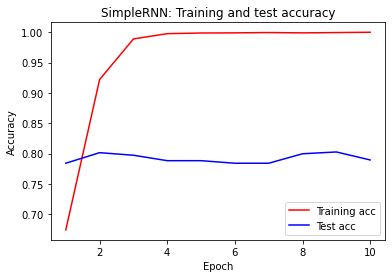

In [35]:
import matplotlib.pyplot as plt

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
rnn_eval = plt.plot(epochs, acc, 'r', label='Training acc')
rnn_eval = plt.plot(epochs, val_acc, 'b', label='Test acc')
rnn_eval = plt.title('SimpleRNN: Training and test accuracy')
rnn_eval = plt.xlabel('Epoch')
rnn_eval = plt.ylabel('Accuracy')
rnn_eval = plt.legend(loc='best')
plt.show()

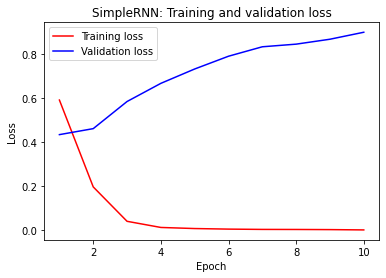

In [36]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('SimpleRNN: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

Model Evaluation: LSTM 

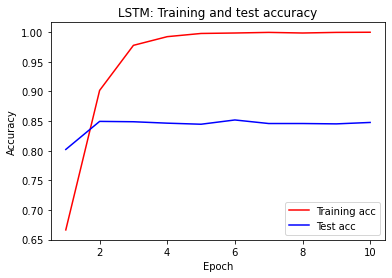

In [37]:
import matplotlib.pyplot as plt

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Test acc')
_ = plt.title('LSTM: Training and test accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

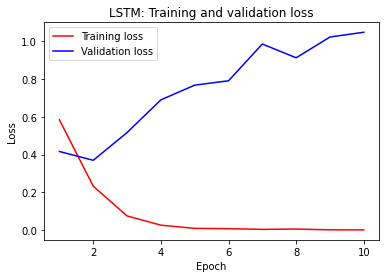

In [38]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

First, we will try to apply a linear model. In this case, we will use Logistic Regression. 

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

logreg = LogisticRegression()
mt_logreg = MultiOutputClassifier(logreg, n_jobs = -1)
mt_logreg.fit(X_train, y_train)

print("Training set score: {:.3f}".format(mt_logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mt_logreg.score(X_test, y_test)))

Training set score: 0.544
Test set score: 0.549


Next algortihm to try is Random Forests Classifier. 

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, random_state=2)

In [42]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.823


As we can see, it has overfitted, as the test accuracy on the training set is perfect, but the test accuracy is very low. We shall try a range of estimators. 

In [43]:
n_range = list(range(1, 101))

In [44]:
training_score = []
test_score = []

for i in n_range:
    forest = RandomForestClassifier(n_estimators = i, random_state = 2)
    forest.fit(X_train, y_train)
    training_score.append(forest.score(X_train, y_train))
    test_score.append(forest.score(X_test, y_test))

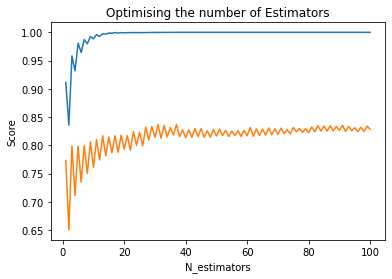

In [45]:
import matplotlib.pyplot as plt

x = n_range
y1 = training_score
y2 = test_score

opt = plt.plot(x, y1, label = 'training')
opt = plt.plot(x, y2, label = "test")
opt = plt.xlabel('N_estimators')
opt = plt.ylabel('Score')
opt = plt.title('Optimising the number of Estimators')
plt.show()

In [46]:
max_value = max(test_score)
opt_n_estimator = test_score.index(max_value) + 1
print(max_value)
print("The best n_estimator for best test accuracy is: {:.1f}".format(opt_n_estimator))

0.8371116708648195
The best n_estimator for best test accuracy is: 37.0


In [47]:
forest = RandomForestClassifier(n_estimators=opt_n_estimator, random_state=2)
forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.837


Use of Kernelized Support Vector Machines, can lead to good results. 

In [89]:
from sklearn.svm import SVC

svc = SVC()
mt_svc = MultiOutputClassifier(svc, n_jobs = -1)
mt_svc.fit(X_train, y_train)

print("Training set score: {:.3f}".format(mt_svc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mt_svc.score(X_test, y_test)))

Training set score: 0.648
Test set score: 0.610


In [86]:
# Testing to see if Standard SVC and Linear SVC have any differences. 

from sklearn.svm import LinearSVC

lsvc = LinearSVC()
mt_lsvc = MultiOutputClassifier(lsvc, n_jobs = -1)
mt_lsvc.fit(X_train, y_train)

print("Training set score: {:.3f}".format(mt_lsvc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mt_lsvc.score(X_test, y_test)))

Training set score: 0.424
Test set score: 0.420


We will also try a Naive Bayes algortihm to see whether it will yield a greater accuracy. 

In [91]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mt_mnb = MultiOutputClassifier(mnb, n_jobs=-1)
mt_mnb.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(mt_mnb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mt_mnb.score(X_test, y_test)))

Accuracy on training set: 0.549
Accuracy on test set: 0.558


As we can see, the accuracy of the model seems very low. We can fix this by scaling the data. We can use scalers provided in the libraries. 

In [51]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer

#I am using the LabelBinarizer(), to see the effect it has on the data. 
lb = LabelBinarizer()

y_train_labelled = lb.fit_transform(y_train)
y_test_labelled = lb.fit_transform(y_test)

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_MM = scaler.fit_transform(X_train)
X_test_MM = scaler.fit_transform(X_test)

We will now use the scaled data to see if the accuracy improves. 

In [87]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
mt_logreg = MultiOutputClassifier(logreg, n_jobs = -1)
mt_logreg.fit(X_train_scaled, y_train)

print("Training set score: {:.3f}".format(mt_logreg.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(mt_logreg.score(X_test_scaled, y_test)))

Training set score: 0.545
Test set score: 0.552


In [88]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=85, random_state=2)
forest.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.821


In [90]:
from sklearn.svm import SVC

svc = SVC()
mt_svc = MultiOutputClassifier(svc, n_jobs = -1)
mt_svc.fit(X_train_MM, y_train)

print("Training set score: {:.3f}".format(mt_svc.score(X_train_MM, y_train)))
print("Test set score: {:.3f}".format(mt_svc.score(X_test_MM, y_test)))

Training set score: 0.648
Test set score: 0.610


We see no increase in the accuracy of the SVC when scaling the data. Weirdly, the accuracy of the Random Forest Classifier and Logistic Regression actually decreased. I also wanted to scale the data a slightly different way, to see if this would affect the accuracy. 


Random Forest would not improve becasue it is not a distance based algorithm, instead being a rule based algorithm, hence the scaling would not improve the accuracy. This also applies to Naive Bayes. 

    

In [57]:
# This is the equivalent to the MinMaxScaler

min_on_training = X_train.min(axis = 0)
range_on_training = (X_train - min_on_training).max(axis = 0)
X_train_manual_scaled = (X_train - min_on_training) / range_on_training

X_test_manual_scaled = (X_test - min_on_training) / range_on_training

In [58]:
svc = SVC()
svc.fit(X_train_manual_scaled, y_train_1D)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_manual_scaled, y_train_1D)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_manual_scaled, y_test_1D)))

Accuracy on training set: 0.648
Accuracy on test set: 0.609


We are seeing if the scaled data improves the accuracy of the Deep Learning Algorithms. 

In [59]:
# Prepare hyperparameters of RNN
vocab_size = len(word_index)+1
output_dim = 32

In [60]:
# SimpleRNN
warnings.filterwarnings("ignore")
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen))
model.add(SimpleRNN(units = output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = output_dim))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 32)            465728    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 14, 32)            2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 14, 32)            2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [62]:
# We are now fitting the model to the training data: 

rnn_hist = model.fit(X_train_MM, y_train, epochs = 10, validation_split = 0.3)

scores = model.evaluate(X_test_MM, y_test, verbose = 0)
warnings.filterwarnings("ignore")

print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

Epoch 1/10
122/122 [==============================] - 3s 13ms/step - loss: 0.6949 - accuracy: 0.5386 - val_loss: 0.6887 - val_accuracy: 0.5474
Epoch 2/10
122/122 [==============================] - 2s 13ms/step - loss: 0.6913 - accuracy: 0.5445 - val_loss: 0.6889 - val_accuracy: 0.5474
Epoch 3/10
122/122 [==============================] - 2s 13ms/step - loss: 0.6904 - accuracy: 0.5506 - val_loss: 0.6887 - val_accuracy: 0.5474
Epoch 4/10
122/122 [==============================] - 1s 12ms/step - loss: 0.6886 - accuracy: 0.5496 - val_loss: 0.6920 - val_accuracy: 0.5474
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 0.6908 - accuracy: 0.5504 - val_loss: 0.6913 - val_accuracy: 0.5468
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 0.6902 - accuracy: 0.5427 - val_loss: 0.6887 - val_accuracy: 0.5474
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 0.6889 - accuracy: 0.5499 - val_loss: 0.6889 - val_accuracy: 0.5474

In [63]:
model.save('srnn.h2')

INFO:tensorflow:Assets written to: srnn.h2\assets


In [64]:
# LSTM Model: 

#Architecture
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen))
model.add(LSTM(units=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(units=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(units=output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 32)            465728    
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [66]:
model.save('lstm.h2')

INFO:tensorflow:Assets written to: lstm.h2\assets


INFO:tensorflow:Assets written to: lstm.h2\assets


In [67]:
lstm_hist = model.fit(X_train_scaled, y_train, epochs=10, validation_split=0.3)
loss = lstm_hist.history
loss.keys()

scores = model.evaluate(X_test_scaled, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
122/122 [==============================] - 6s 25ms/step - loss: 0.6895 - accuracy: 0.5458 - val_loss: 0.6894 - val_accuracy: 0.5474
Epoch 2/10
122/122 [==============================] - 3s 23ms/step - loss: 0.6894 - accuracy: 0.5504 - val_loss: 0.6886 - val_accuracy: 0.5474
Epoch 3/10
122/122 [==============================] - 2s 19ms/step - loss: 0.6888 - accuracy: 0.5504 - val_loss: 0.6885 - val_accuracy: 0.5474
Epoch 4/10
122/122 [==============================] - 2s 18ms/step - loss: 0.6883 - accuracy: 0.5504 - val_loss: 0.6881 - val_accuracy: 0.5474
Epoch 5/10
122/122 [==============================] - 2s 18ms/step - loss: 0.6877 - accuracy: 0.5504 - val_loss: 0.6874 - val_accuracy: 0.5474
Epoch 6/10
122/122 [==============================] - 2s 18ms/step - loss: 0.6881 - accuracy: 0.5504 - val_loss: 0.6868 - val_accuracy: 0.5474
Epoch 7/10
122/122 [==============================] - 2s 18ms/step - loss: 0.6869 - accuracy: 0.5504 - val_loss: 0.6847 - val_accuracy: 0.5474

Advice given to me said that scaling data would really improve the accuracy of neural networks, but it seems of have the opposite effect on my RNN and LSTM models. I will research into why this was the case. 

Model Evaluation: Simple RNN

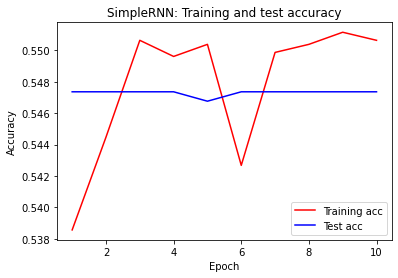

In [68]:
import matplotlib.pyplot as plt

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
rnn_eval = plt.plot(epochs, acc, 'r', label='Training acc')
rnn_eval = plt.plot(epochs, val_acc, 'b', label='Test acc')
rnn_eval = plt.title('SimpleRNN: Training and test accuracy')
rnn_eval = plt.xlabel('Epoch')
rnn_eval = plt.ylabel('Accuracy')
rnn_eval = plt.legend(loc='best')
plt.show()

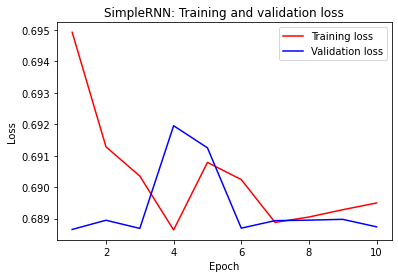

In [69]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('SimpleRNN: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

Model Evaluation: LSTM 

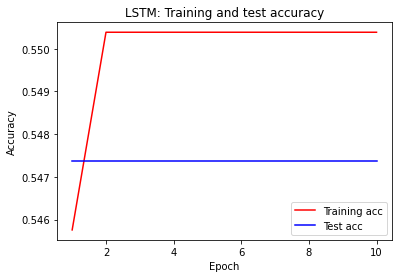

In [70]:
import matplotlib.pyplot as plt

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Test acc')
_ = plt.title('LSTM: Training and test accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

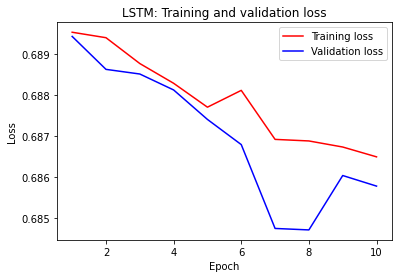

In [71]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

Having created our models, we will continue to optimise them to improve accuracy. We will use this by evaluating our modles using the tools provided by the sklearn library. 

In [93]:
# We need to create the random grid of parameters to apply the RandomizedSearchCV to. 

from pprint import pprint 

print('Parameters in use:\n')
pprint(forest.get_params())

Parameters in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 85,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


In [99]:
# We will choose the parameters to improve and add them to a grid. 

n_esimators = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators' : n_esimators,
               'max_features' : max_features,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf' : min_samples_leaf,
               'bootstrap' : bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [0, 222, 444, 666, 888, 1111, 1333, 1555, 1777, 2000]}


In [100]:
from sklearn.model_selection import RandomizedSearchCV

start = time.time()

forest_random = RandomizedSearchCV(estimator= forest, param_distributions= random_grid, scoring = 'neg_mean_absolute_error',
                                    n_iter=100, cv = 3, verbose = 2, random_state=2, n_jobs= -1, return_train_score = True)

forest_random.fit(X_train, y_train)

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training duration(minutes): 15.806758995850881


In [96]:
forest_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'bootstrap': False}

In [98]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=800, random_state=2, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', bootstrap=False)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.841


This has increased accuracy by 2.2%, which seems like a very small return for the amount of processing time. We will now use the predict on our data and compare it to the original labelled data. 

In [101]:
from keras.models import load_model

lstm = load_model('lstm.h5')
warnings.filterwarnings('ignore')

In [102]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 32)            465728    
_________________________________________________________________
lstm (LSTM)                  (None, 14, 32)            8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [103]:
predictions = lstm.predict(X_test)

In [104]:
probability_positive = predictions[:,1]

In [105]:
len(probability_positive)

2382